In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

folder_path = "/content/drive/My Drive/EDAI"  # Replace with your actual folder path
files = os.listdir(folder_path)

print("Files in folder:", files)


Files in folder: ['000031.png', '000014.png', '000000 - Copy.png', '000034.png', '000000.png', '000015.png', '000024.png', '000013.png', '000016.png', '000010.png', '000020.png', '000032.png', '000003.png', '000030.png', '000005.png', '000006.png', '000021.png', '000008.png', '000017.png', '000027.png', '000004.png', '000025.png', '000028.png', '000002.png', '000007.png', '000026.png', '000000 (1).png', '000012.png', '000023.png', '000018.png', '000019.png', '000022.png', '000001.png', '000011.png', '000033.png', '000029.png', '000009.png', '000060.png', '000066.png', '000058.png', '000051.png', '000036.png', '000049.png', '000040.png', '000043.png', '000072.png', '000069.png', '000050.png', '000077.png', '000061.png', '000038.png', '000055.png', '000037.png', '000076.png', '000035.png', '000075.png', '000042.png', '000070.png', '000047.png', '000057.png', '000064.png', '000054.png', '000068.png', '000074.png', '000041.png', '000071.png', '000062.png', '000045.png', '000048.png', '0000

In [ ]:
!pip install opencv-python matplotlib torch torchvision timm


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


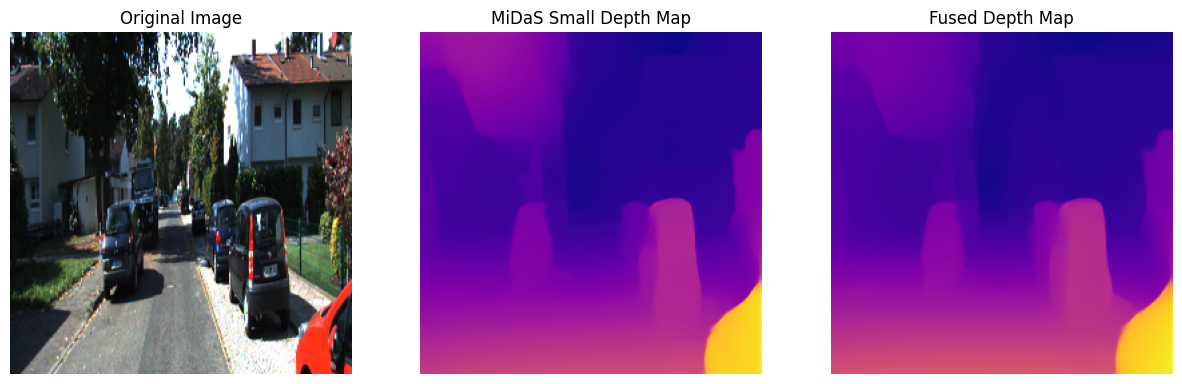

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor

# Load MiDaS (small model)
midas_small = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")  # Use "DPT_Large" for better quality
midas_small.eval()

# Load DPT_Large model
midas_large = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas_large.eval()

# Load and preprocess the image
image_path = "/content/drive/My Drive/EDAI/000031.png"  # Replace with your actual image path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))  # Resize to model input size

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_batch = transform(img).unsqueeze(0)

# Run depth estimation on both models
with torch.no_grad():
    depth_map_small = midas_small(input_batch).squeeze().cpu().numpy()
    depth_map_large = midas_large(input_batch).squeeze().cpu().numpy()

# Normalize both depth maps
depth_map_small = (depth_map_small - depth_map_small.min()) / (depth_map_small.max() - depth_map_small.min())
depth_map_large = (depth_map_large - depth_map_large.min()) / (depth_map_large.max() - depth_map_large.min())

# Weighted fusion of depth maps
fused_depth_map = 0.6 * depth_map_small + 0.4 * depth_map_large

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(depth_map_small, cmap="plasma")
plt.title("MiDaS Small Depth Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(fused_depth_map, cmap="plasma")
plt.title("Fused Depth Map")
plt.axis("off")

plt.show()


In [ ]:
#Approaches with comparisons

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor
from cv2.ximgproc import guidedFilter

# Load models
dpt_large = torch.hub.load("intel-isl/MiDaS", "DPT_Large").eval()
dpt_hybrid = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid").eval()

# Load and preprocess image
image_path = "/content/drive/My Drive/EDAI/000031.png"
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (384, 384))

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(img_resized).unsqueeze(0)

# Estimate depth
with torch.no_grad():
    depth_large = dpt_large(input_tensor).squeeze().cpu().numpy()
    depth_hybrid = dpt_hybrid(input_tensor).squeeze().cpu().numpy()

# Normalize
depth_large = (depth_large - depth_large.min()) / (depth_large.max() - depth_large.min())
depth_hybrid = (depth_hybrid - depth_hybrid.min()) / (depth_hybrid.max() - depth_hybrid.min())

# Fuse and filter
fused = 0.5 * depth_large + 0.5 * depth_hybrid
fused_filtered = guidedFilter(img_resized, fused.astype(np.float32), radius=8, eps=1e-2)

# Plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(depth_large, cmap="plasma"); plt.title("DPT_Large"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(depth_hybrid, cmap="plasma"); plt.title("DPT_Hybrid"); plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(fused_filtered, cmap="plasma"); plt.title("Fused + Guided Filter"); plt.axis("off")
plt.show()


In [ ]:
!pip install open3d

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


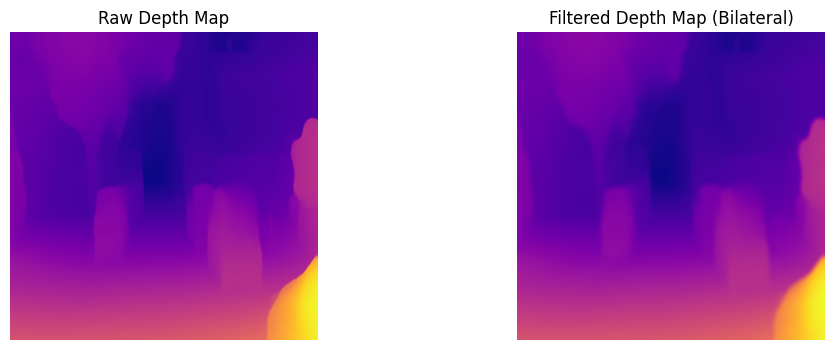

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from torchvision.transforms import Compose, Normalize, ToTensor

# Load DPT_Large Model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.eval()

# Use official transform for DPT models
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# Load image (higher resolution)
image_path = "/content/drive/My Drive/EDAI/000031.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (384, 384))  # Higher resolution input

# Prepare input batch
input_tensor = transform(img)

# Predict depth
with torch.no_grad():
    depth_map = midas(input_tensor).squeeze().cpu().numpy()

# Normalize depth map
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Bilateral filter for depth smoothing
depth_map_filtered = cv2.bilateralFilter(depth_map.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# Show original vs filtered depth map
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(depth_map, cmap='plasma')
plt.title("Raw Depth Map")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_map_filtered, cmap='plasma')
plt.title("Filtered Depth Map (Bilateral)")
plt.axis("off")
plt.show()

# Convert to Open3D Point Cloud
def create_point_cloud(depth_map, img, fx=500.0, fy=500.0):
    height, width = depth_map.shape
    cx, cy = width / 2.0, height / 2.0

    # Convert to Open3D RGBD Image
    color_o3d = o3d.geometry.Image(img)
    depth_o3d = o3d.geometry.Image((depth_map * 1000).astype(np.uint16))  # Scale for Open3D
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_o3d, depth_o3d,
        convert_rgb_to_intensity=False
    )

    # Set camera intrinsics
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

    # Create point cloud and downsample
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
    pcd = pcd.voxel_down_sample(voxel_size=0.01)  # Optional: reduce point count
    pcd.estimate_normals()  # Optional: improves visualization shading

    return pcd

# Generate and visualize point cloud
point_cloud = create_point_cloud(depth_map_filtered, img)
o3d.visualization.draw_geometries([point_cloud])


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


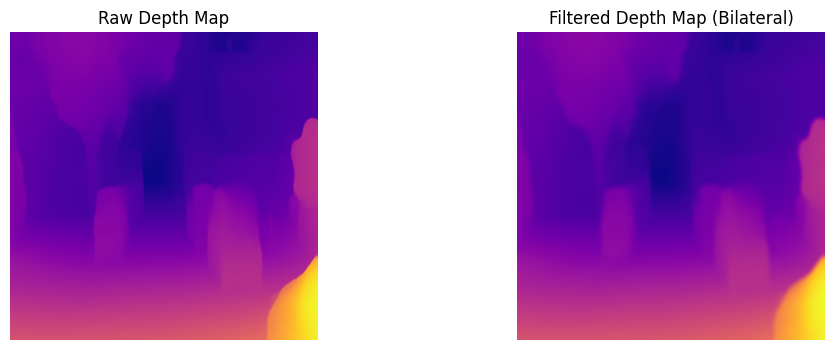

Depth Map Variance:
  Raw:      0.030649
  Filtered: 0.030495
Visualizing: Left = Raw (Red), Right = Filtered (Green)
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from torchvision.transforms import Compose, Normalize, ToTensor

# Load DPT_Large Model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.eval()

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# Load and preprocess image
image_path = "/content/drive/My Drive/EDAI/000031.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (384, 384))  # Resize to model expected input
input_tensor = transform(img)

# Predict depth
with torch.no_grad():
    depth_map = midas(input_tensor).squeeze().cpu().numpy()

# Normalize depth
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Bilateral filtering for smoothing
depth_map_filtered = cv2.bilateralFilter(depth_map.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# Compare raw vs filtered depth maps
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(depth_map, cmap='plasma')
plt.title("Raw Depth Map")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_map_filtered, cmap='plasma')
plt.title("Filtered Depth Map (Bilateral)")
plt.axis("off")
plt.show()

# Depth map variance comparison
var_raw = np.var(depth_map)
var_filtered = np.var(depth_map_filtered)
print(f"Depth Map Variance:\n  Raw:      {var_raw:.6f}\n  Filtered: {var_filtered:.6f}")

# Function to create point cloud from depth and color
def create_point_cloud(depth_map, img, fx=500.0, fy=500.0):
    height, width = depth_map.shape
    cx, cy = width / 2.0, height / 2.0

    # Resize image to match depth if needed
    img_resized = cv2.resize(img, (width, height))

    # Create Open3D RGBD image
    color_o3d = o3d.geometry.Image(img_resized)
    depth_o3d = o3d.geometry.Image((depth_map * 1000).astype(np.uint16))  # scale for depth in mm
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_o3d, depth_o3d, convert_rgb_to_intensity=False
    )

    # Camera intrinsics
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

    # Generate and downsample point cloud
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    pcd.estimate_normals()
    return pcd

# Create raw and filtered point clouds
point_cloud_raw = create_point_cloud(depth_map, img)
point_cloud_filtered = create_point_cloud(depth_map_filtered, img)

# Paint and shift for side-by-side view
point_cloud_raw.paint_uniform_color([1, 0, 0])       # Red
point_cloud_filtered.paint_uniform_color([0, 1, 0])  # Green
point_cloud_filtered.translate((0.2, 0, 0))          # Shift to right for comparison

# Show both point clouds side by side
print("Visualizing: Left = Raw (Red), Right = Filtered (Green)")
o3d.visualization.draw_geometries([point_cloud_raw, point_cloud_filtered])


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


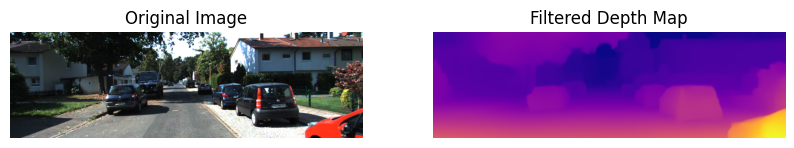

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# Load MiDaS model and transform
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# Load high-res image (do not resize manually)
image_path = "/content/drive/My Drive/EDAI/000031.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = transform(img)

# Predict depth
with torch.no_grad():
    prediction = midas(input_tensor)
    depth_map = prediction.squeeze().cpu().numpy()

# Apply bilateral filtering to smooth depth map
depth_filtered = cv2.bilateralFilter(depth_map.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# Normalize for visualization and point cloud scaling
depth_filtered = (depth_filtered - np.min(depth_filtered)) / (np.max(depth_filtered) - np.min(depth_filtered))
depth_filtered *= 10  # Optional scale factor for better depth spacing

# Show filtered depth map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_filtered, cmap="plasma")
plt.title("Filtered Depth Map")
plt.axis("off")
plt.show()

# Convert to point cloud
def depth_to_point_cloud(depth_map, img, scale=1.0):
    h, w = depth_map.shape
    fx = fy = 500 * scale
    cx, cy = w / 2, h / 2

    points = []
    colors = []

    for i in range(h):
        for j in range(w):
            z = depth_map[i, j]
            x = (j - cx) * z / fx
            y = (i - cy) * z / fy
            points.append((x, y, z))
            colors.append(img[i, j] / 255.0)

    points = np.array(points)
    colors = np.array(colors)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

# Generate raw point cloud
# Resize image to match depth map dimensions
img_resized = cv2.resize(img, (depth_filtered.shape[1], depth_filtered.shape[0]))
pcd = depth_to_point_cloud(depth_filtered, img_resized)


# Downsample for performance
pcd = pcd.voxel_down_sample(voxel_size=0.01)

# Estimate normals
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30))

# Visualize point cloud
o3d.visualization.draw_geometries([pcd], point_show_normal=False)

# OPTIONAL: Convert to triangle mesh using Ball Pivoting
# radii = [0.005, 0.01, 0.02]
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
#     pcd, o3d.utility.DoubleVector(radii)
# )
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])


In [ ]:
!pip install open3d
import open3d as o3d
def depth_to_point_cloud(depth_map, img):
    h, w = depth_map.shape
    fx = fy = 500  # Focal length (adjust based on camera properties)
    cx, cy = w / 2, h / 2  # Principal point

    points = []
    colors = []

    for i in range(h):
        for j in range(w):
            z = depth_map[i, j] * 10  # Scale depth
            x = (j - cx) * z / fx
            y = (i - cy) * z / fy
            points.append((x, y, z))
            colors.append(img[i, j] / 255.0)  # Normalize colors

    points = np.array(points)
    colors = np.array(colors)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    return point_cloud

# Generate and visualize point cloud
point_cloud = depth_to_point_cloud(fused_depth_map, img)
o3d.visualization.draw_geometries([point_cloud])


[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
# Save point cloud
o3d.io.write_point_cloud("point_cloud.ply", point_cloud)

# Convert to mesh and save as OBJ
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(point_cloud, alpha=0.03)
o3d.io.write_triangle_mesh("model.obj", mesh)


True

In [ ]:
import open3d as o3d

# Get image dimensions
h, w = depth_map.shape

# Create a mesh grid of (x, y) coordinates
x, y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))

# Flatten the arrays
x = x.flatten()
y = y.flatten()
z = depth_map.flatten()  # Use depth map as Z values

# Stack as (x, y, z) points
points = np.vstack((x, y, z)).T

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Save and visualize the point cloud
o3d.io.write_point_cloud("depth_point_cloud.ply", pcd)
o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
# Create a mesh from the depth map using Open3D
pcd.estimate_normals()
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)[0]

# Save and visualize the 3D mesh
o3d.io.write_triangle_mesh("3d_model.obj", mesh)
o3d.visualization.draw_geometries([mesh])


[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


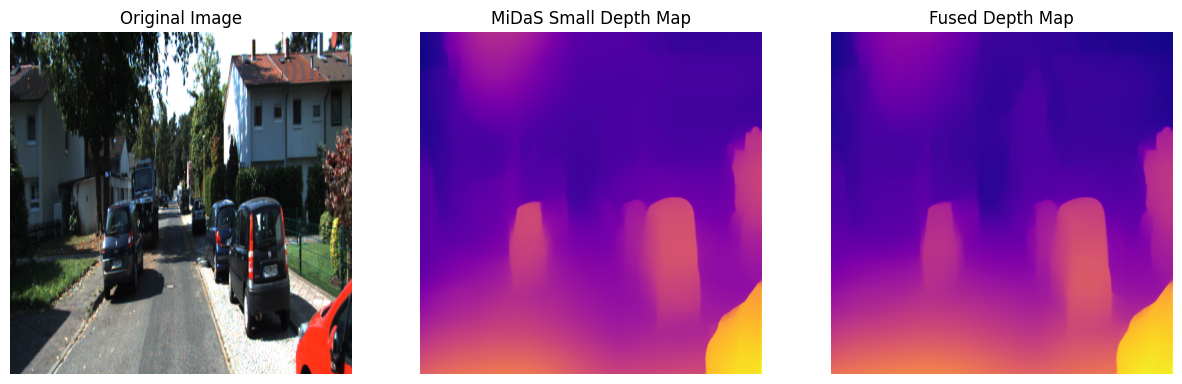

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Creating Mesh...
[Open3D WARNING] Write OBJ can not include triangle normals.
Mesh saved as model.obj


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from torchvision.transforms import Compose, Normalize, ToTensor

# Load MiDaS (small model)
midas_small = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas_small.eval()

# Load DPT_Large model
midas_large = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas_large.eval()

# Load and preprocess the image
image_path = "/content/drive/My Drive/EDAI/000031.png"  # Replace with your actual image path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))  # Increase resolution for better details

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_batch = transform(img).unsqueeze(0)

# Run depth estimation on both models
with torch.no_grad():
    depth_map_small = midas_small(input_batch).squeeze().cpu().numpy()
    depth_map_large = midas_large(input_batch).squeeze().cpu().numpy()

# Normalize both depth maps
depth_map_small = (depth_map_small - depth_map_small.min()) / (depth_map_small.max() - depth_map_small.min())
depth_map_large = (depth_map_large - depth_map_large.min()) / (depth_map_large.max() - depth_map_large.min())

# Weighted fusion of depth maps
fused_depth_map = 0.6 * depth_map_small + 0.4 * depth_map_large

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(depth_map_small, cmap="plasma")
plt.title("MiDaS Small Depth Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(fused_depth_map, cmap="plasma")
plt.title("Fused Depth Map")
plt.axis("off")

plt.show()

# Convert depth map to 3D point cloud
def depth_to_point_cloud(depth_map, img):
    h, w = depth_map.shape
    fx = fy = 700  # Adjust focal length for better scaling
    cx, cy = w / 2, h / 2  # Principal point

    points = []
    colors = []

    for i in range(h):
        for j in range(w):
            z = depth_map[i, j] * 10  # Scale depth
            x = (j - cx) * z / fx
            y = (i - cy) * z / fy
            points.append((x, y, z))
            colors.append(img[i, j] / 255.0)  # Normalize colors

    points = np.array(points)
    colors = np.array(colors)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    return point_cloud

# Generate and visualize point cloud
point_cloud = depth_to_point_cloud(fused_depth_map, img)
o3d.visualization.draw_geometries([point_cloud])

# Save point cloud
o3d.io.write_point_cloud("point_cloud.ply", point_cloud)

# Estimate normals for Poisson reconstruction
point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=30))

# Convert to mesh using Poisson surface reconstruction
print("Creating Mesh...")
poisson_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=8)
poisson_mesh.compute_vertex_normals()

# Save the mesh
o3d.io.write_triangle_mesh("model.obj", poisson_mesh)
print("Mesh saved as model.obj")



Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


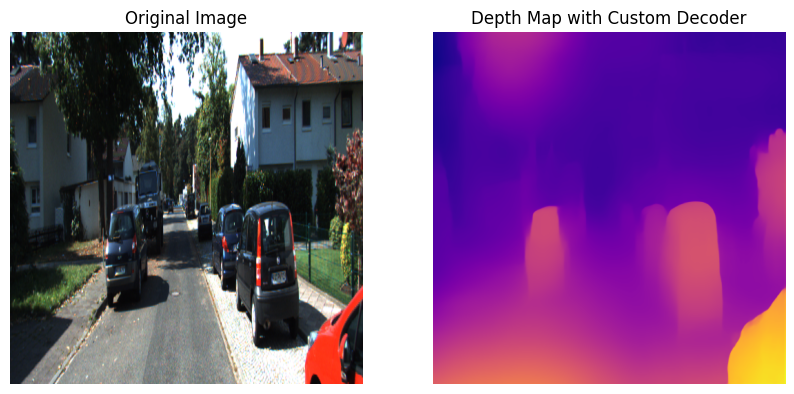

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Creating Mesh...
[Open3D WARNING] Write OBJ can not include triangle normals.
Mesh saved as model.obj


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from torchvision.transforms import Compose, Normalize, ToTensor

# Load MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small", pretrained=True)
midas.eval()

# Define a custom decoder with transposed convolutions
class CustomDecoder(nn.Module):
    def __init__(self, in_channels):
        super(CustomDecoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(in_channels, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.out = nn.Conv2d(32, 1, kernel_size=1)  # Output 1-channel depth map

    def forward(self, x):
        x = torch.relu(self.up1(x))
        x = torch.relu(self.up2(x))
        x = torch.relu(self.up3(x))
        x = self.out(x)
        return x

# Replace the MiDaS decoder with the custom one
midas.decoder = CustomDecoder(in_channels=64)  # Adjust input channels based on MiDaS architecture

# Load and preprocess image
image_path = "/content/drive/My Drive/EDAI/000031.png"  # Replace with your image path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))  # Resize to maintain quality

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_batch = transform(img).unsqueeze(0)

# Run modified MiDaS with the custom decoder
with torch.no_grad():
    depth_map = midas(input_batch).squeeze().cpu().numpy()

# Normalize depth map
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap="plasma")
plt.title("Depth Map with Custom Decoder")
plt.axis("off")

plt.show()

# Convert depth map to 3D point cloud
def depth_to_point_cloud(depth_map, img):
    h, w = depth_map.shape
    fx = fy = 700  # Adjust focal length for scaling
    cx, cy = w / 2, h / 2

    points = []
    colors = []

    for i in range(h):
        for j in range(w):
            z = depth_map[i, j] * 10
            x = (j - cx) * z / fx
            y = (i - cy) * z / fy
            points.append((x, y, z))
            colors.append(img[i, j] / 255.0)

    points = np.array(points)
    colors = np.array(colors)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    return point_cloud

# Generate and visualize point cloud
point_cloud = depth_to_point_cloud(depth_map, img)
o3d.visualization.draw_geometries([point_cloud])

# Save point cloud
o3d.io.write_point_cloud("new_point_cloud.ply", point_cloud)

# Compute normals for Poisson reconstruction
point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=30))

# Convert to mesh using Poisson surface reconstruction
print("Creating Mesh...")
poisson_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=8)
poisson_mesh.compute_vertex_normals()
o3d.io.write_triangle_mesh("new_model.obj", poisson_mesh)
print("Mesh saved as model.obj")


In [ ]:
#Approches for comparison

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


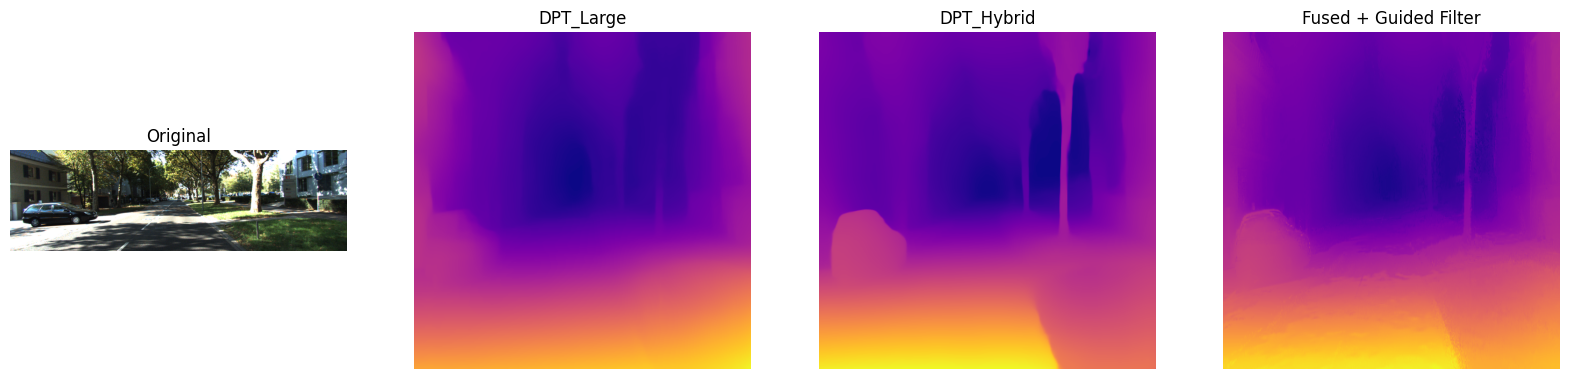

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor
from cv2.ximgproc import guidedFilter

# Load models
dpt_large = torch.hub.load("intel-isl/MiDaS", "DPT_Large").eval()
dpt_hybrid = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid").eval()

# Load and preprocess image
image_path = "/content/drive/My Drive/EDAI/000034.png"
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (384, 384))

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(img_resized).unsqueeze(0)

# Estimate depth
with torch.no_grad():
    depth_large = dpt_large(input_tensor).squeeze().cpu().numpy()
    depth_hybrid = dpt_hybrid(input_tensor).squeeze().cpu().numpy()

# Normalize
depth_large = (depth_large - depth_large.min()) / (depth_large.max() - depth_large.min())
depth_hybrid = (depth_hybrid - depth_hybrid.min()) / (depth_hybrid.max() - depth_hybrid.min())

# Fuse and filter
fused = 0.5 * depth_large + 0.5 * depth_hybrid
fused_filtered = guidedFilter(img_resized, fused.astype(np.float32), radius=8, eps=1e-2)

# Plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(depth_large, cmap="plasma"); plt.title("DPT_Large"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(depth_hybrid, cmap="plasma"); plt.title("DPT_Hybrid"); plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(fused_filtered, cmap="plasma"); plt.title("Fused + Guided Filter"); plt.axis("off")
plt.show()


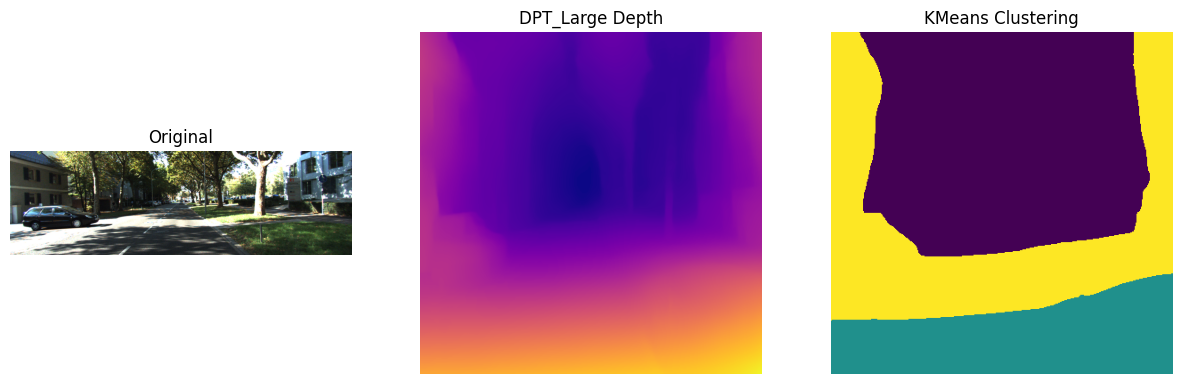

In [ ]:
from sklearn.cluster import KMeans

# Use depth_large from previous code
depth_flat = depth_large.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42).fit(depth_flat)
clustered = kmeans.labels_.reshape(depth_large.shape)

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(depth_large, cmap='plasma'); plt.title("DPT_Large Depth"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(clustered, cmap='viridis'); plt.title("KMeans Clustering"); plt.axis("off")
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


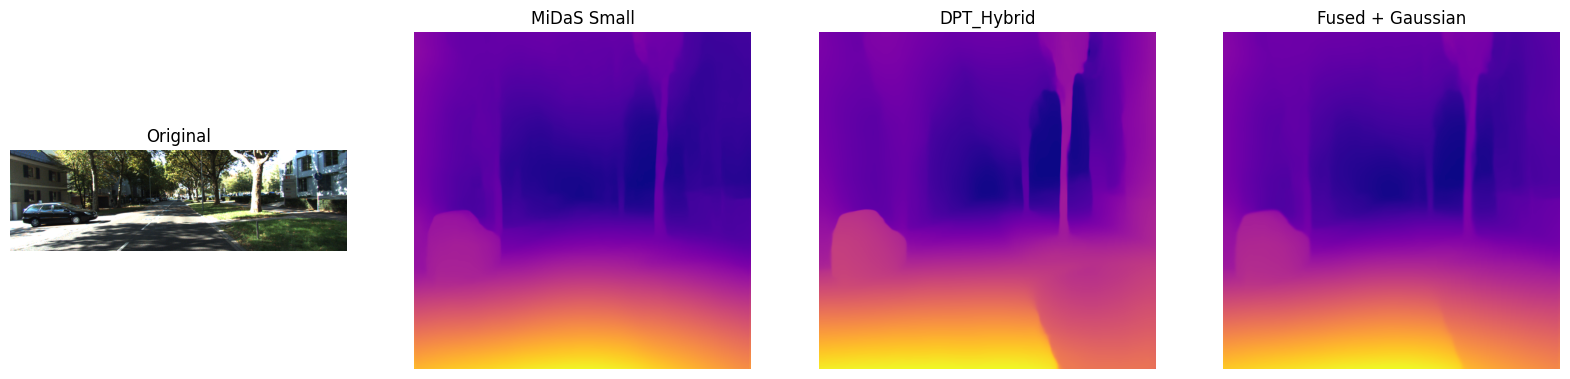

In [ ]:
# Load MiDaS_small
midas_small = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").eval()

# Estimate depths
with torch.no_grad():
    depth_small = midas_small(input_tensor).squeeze().cpu().numpy()
    depth_hybrid = dpt_hybrid(input_tensor).squeeze().cpu().numpy()

# Normalize
depth_small = (depth_small - depth_small.min()) / (depth_small.max() - depth_small.min())
depth_hybrid = (depth_hybrid - depth_hybrid.min()) / (depth_hybrid.max() - depth_hybrid.min())

# Fuse and filter
fused = 0.7 * depth_small + 0.3 * depth_hybrid
fused_smoothed = cv2.GaussianBlur(fused, (5, 5), sigmaX=1)

# Plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(depth_small, cmap='plasma'); plt.title("MiDaS Small"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(depth_hybrid, cmap='plasma'); plt.title("DPT_Hybrid"); plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(fused_smoothed, cmap='plasma'); plt.title("Fused + Gaussian"); plt.axis("off")
plt.show()


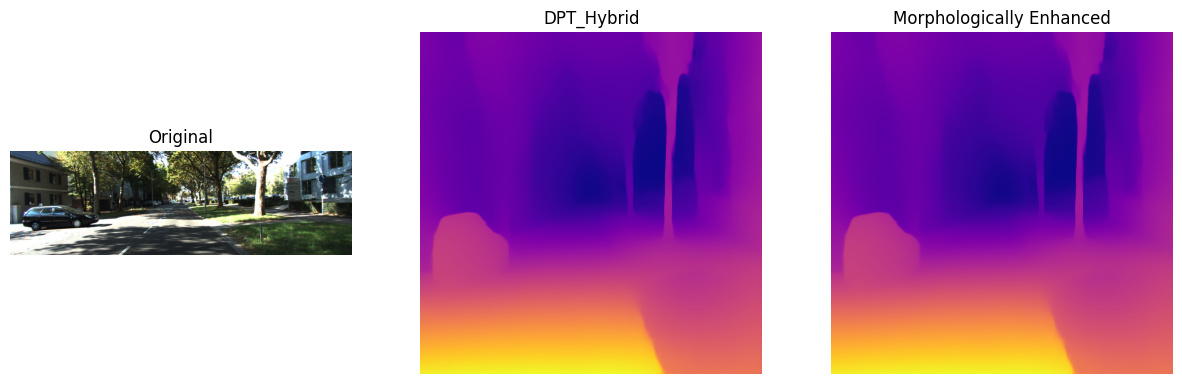

In [ ]:
# Use depth_hybrid from earlier
depth_morph = cv2.morphologyEx(np.uint8(depth_hybrid * 255), cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(depth_hybrid, cmap='plasma'); plt.title("DPT_Hybrid"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(depth_morph, cmap='plasma'); plt.title("Morphologically Enhanced"); plt.axis("off")
plt.show()


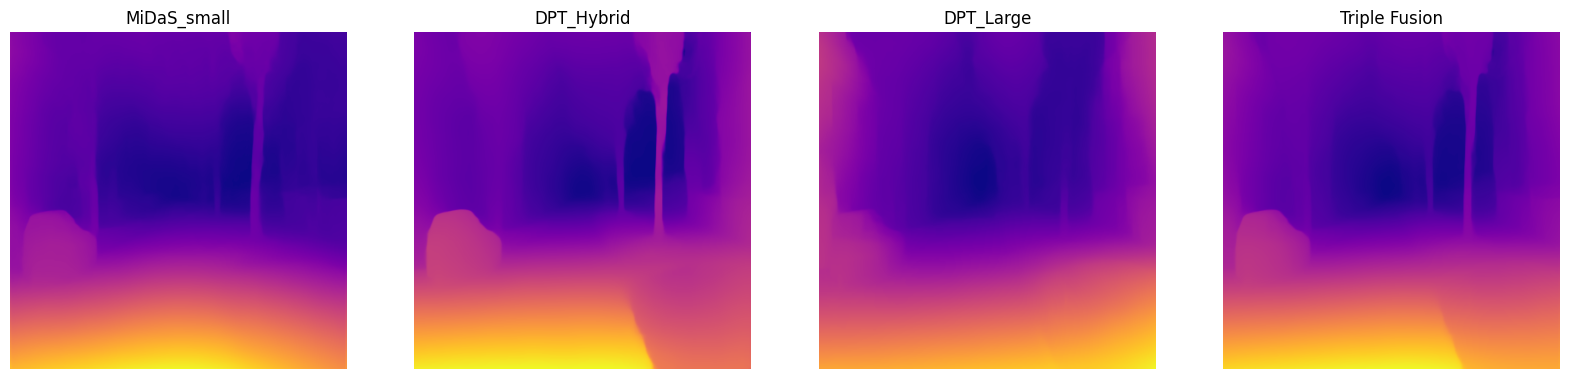

In [ ]:
# Already loaded: midas_small, dpt_hybrid, dpt_large

with torch.no_grad():
    depth_small = midas_small(input_tensor).squeeze().cpu().numpy()
    depth_hybrid = dpt_hybrid(input_tensor).squeeze().cpu().numpy()
    depth_large = dpt_large(input_tensor).squeeze().cpu().numpy()

# Normalize
def norm(d): return (d - d.min()) / (d.max() - d.min())
depth_small = norm(depth_small)
depth_hybrid = norm(depth_hybrid)
depth_large = norm(depth_large)

# Weighted fusion
fused = 0.3 * depth_small + 0.4 * depth_hybrid + 0.3 * depth_large

# Plot
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1); plt.imshow(depth_small, cmap="plasma"); plt.title("MiDaS_small"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(depth_hybrid, cmap="plasma"); plt.title("DPT_Hybrid"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(depth_large, cmap="plasma"); plt.title("DPT_Large"); plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(fused, cmap="plasma"); plt.title("Triple Fusion"); plt.axis("off")
plt.show()


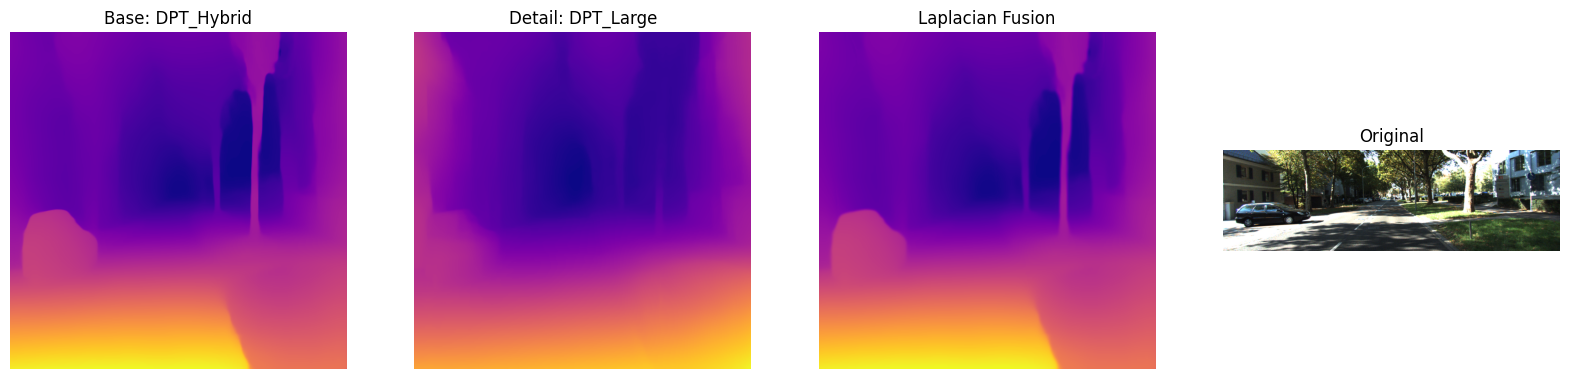

In [ ]:
def laplacian_fusion(base, detail):
    base_blur = cv2.GaussianBlur(base, (5, 5), 0)
    lap_detail = cv2.Laplacian(detail.astype(np.float32), cv2.CV_32F)
    return np.clip(base_blur + 0.3 * lap_detail, 0, 1)

lap_fused = laplacian_fusion(depth_hybrid, depth_large)

# Plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1); plt.imshow(depth_hybrid, cmap='plasma'); plt.title("Base: DPT_Hybrid"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(depth_large, cmap='plasma'); plt.title("Detail: DPT_Large"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(lap_fused, cmap='plasma'); plt.title("Laplacian Fusion"); plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.show()


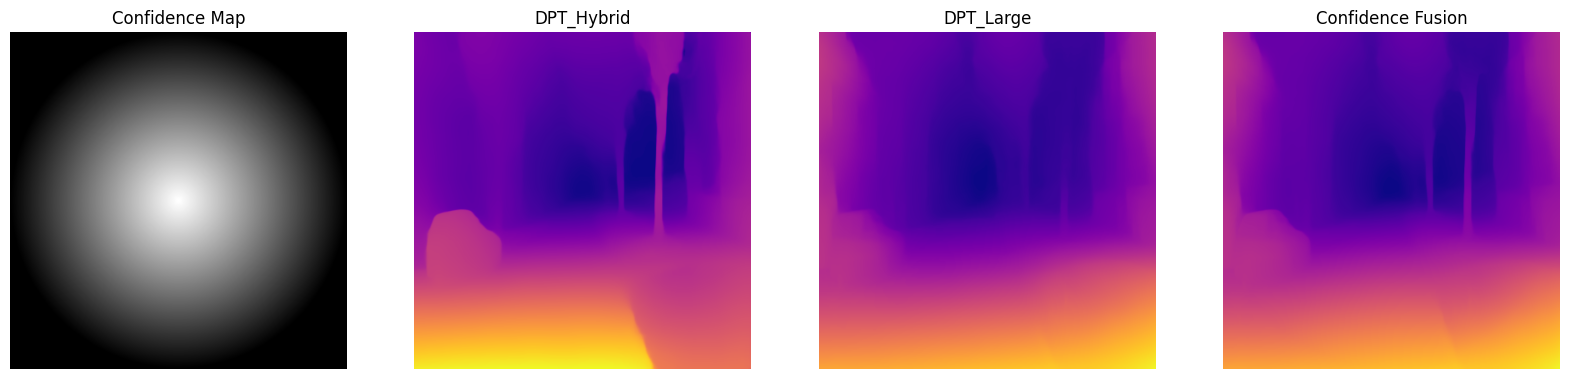

In [ ]:
# Create radial confidence map centered in image
h, w = depth_hybrid.shape
x, y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
conf_map = 1 - np.sqrt(x**2 + y**2)
conf_map = np.clip(conf_map, 0, 1)

fused_conf = conf_map * depth_hybrid + (1 - conf_map) * depth_large

# Plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1); plt.imshow(conf_map, cmap='gray'); plt.title("Confidence Map"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(depth_hybrid, cmap='plasma'); plt.title("DPT_Hybrid"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(depth_large, cmap='plasma'); plt.title("DPT_Large"); plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(fused_conf, cmap='plasma'); plt.title("Confidence Fusion"); plt.axis("off")
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Approach: DPT_Large
Mean Edge Strength: 0.0045
Shannon Entropy: 5.2529


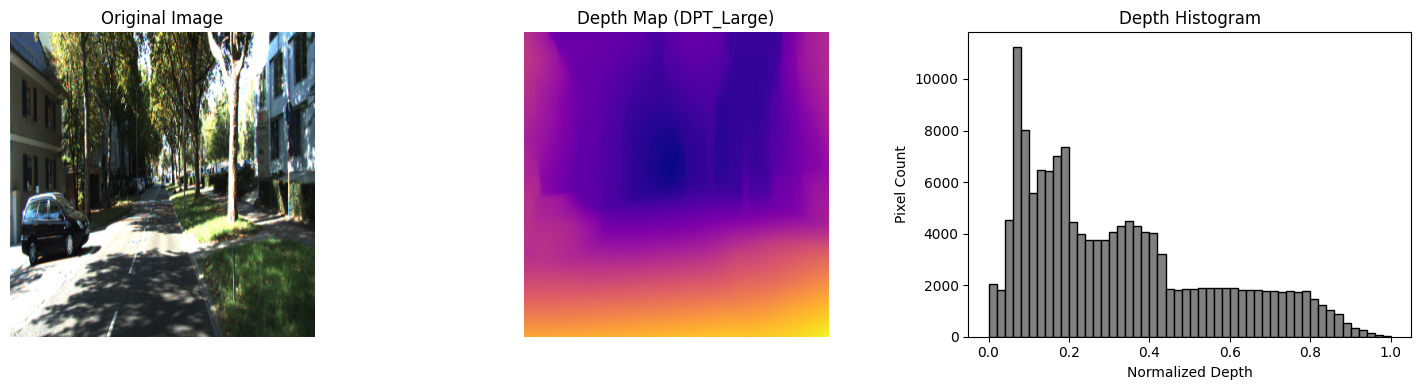

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor
from skimage.filters import sobel
from scipy.stats import entropy as shannon_entropy

# --- Load and preprocess image ---
image_path = "/content/drive/My Drive/EDAI/000034.png"  # Change path as needed
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (384, 384))

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])
input_tensor = transform(img_resized).unsqueeze(0)

# --- Load DPT_Large model ---
model = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
model.eval()

# --- Run inference ---
with torch.no_grad():
    depth = model(input_tensor).squeeze().cpu().numpy()

# --- Normalize depth ---
depth = (depth - depth.min()) / (depth.max() - depth.min())

# --- Compute evaluation metrics ---
# Sobel edge strength
sobel_edges = sobel(depth)
edge_strength = np.mean(sobel_edges)

# Entropy
hist, _ = np.histogram(depth.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)  # add epsilon to avoid log(0)

# --- Print metrics ---
print(f"Approach: DPT_Large")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(depth, cmap='plasma')
plt.title("Depth Map (DPT_Large)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.hist(depth.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")

plt.tight_layout()
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Approach: DPT_Hybrid
Mean Edge Strength: 0.0056
Shannon Entropy: 5.2833


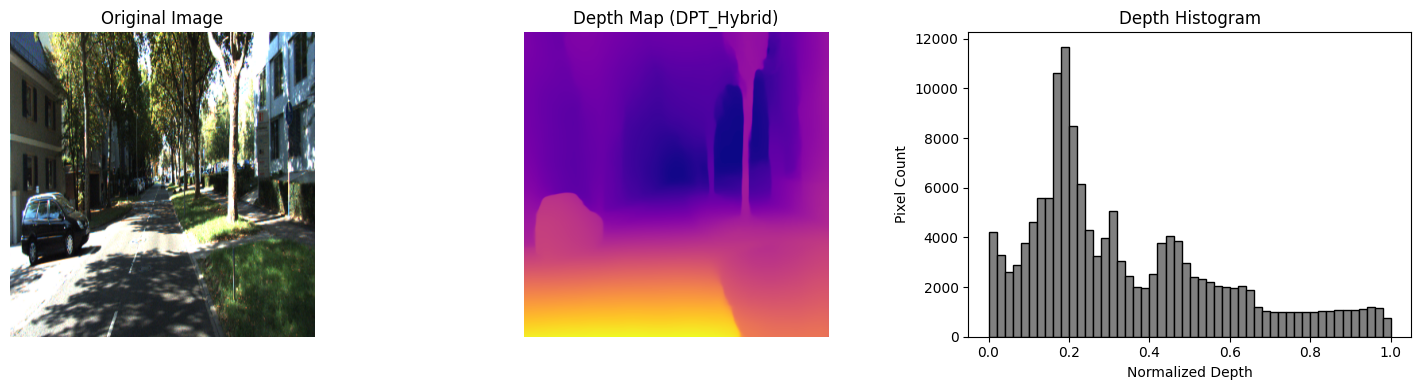

In [ ]:
# --- Load DPT_Hybrid model ---
model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
model.eval()

# --- Run inference ---
with torch.no_grad():
    depth_hybrid = model(input_tensor).squeeze().cpu().numpy()

# --- Normalize depth ---
depth_hybrid = (depth_hybrid - depth_hybrid.min()) / (depth_hybrid.max() - depth_hybrid.min())

# --- Compute evaluation metrics ---
sobel_edges = sobel(depth_hybrid)
edge_strength = np.mean(sobel_edges)

hist, _ = np.histogram(depth_hybrid.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)

# --- Print metrics ---
print(f"Approach: DPT_Hybrid")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(depth_hybrid, cmap='plasma')
plt.title("Depth Map (DPT_Hybrid)")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.hist(depth_hybrid.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Approach: MiDaS Small
Mean Edge Strength: 0.0048
Shannon Entropy: 5.1650


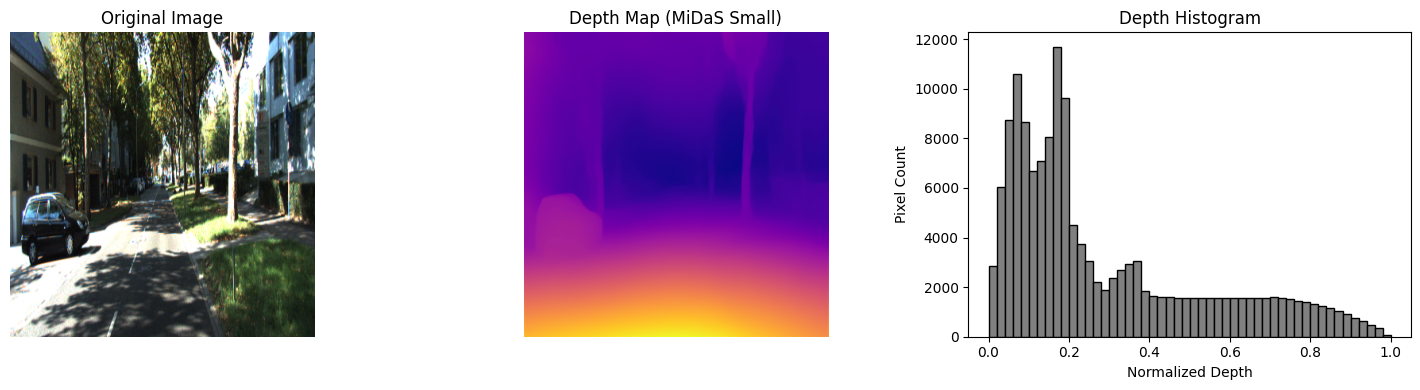

In [ ]:
# --- Load MiDaS Small model ---
model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
model.eval()

# --- Run inference ---
with torch.no_grad():
    depth_small = model(input_tensor).squeeze().cpu().numpy()

# --- Normalize depth ---
depth_small = (depth_small - depth_small.min()) / (depth_small.max() - depth_small.min())

# --- Compute evaluation metrics ---
sobel_edges = sobel(depth_small)
edge_strength = np.mean(sobel_edges)

hist, _ = np.histogram(depth_small.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)

# --- Print metrics ---
print(f"Approach: MiDaS Small")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(depth_small, cmap='plasma')
plt.title("Depth Map (MiDaS Small)")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.hist(depth_small.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()


Approach: Fusion Guided
Mean Edge Strength: 0.0055
Shannon Entropy: 5.2563


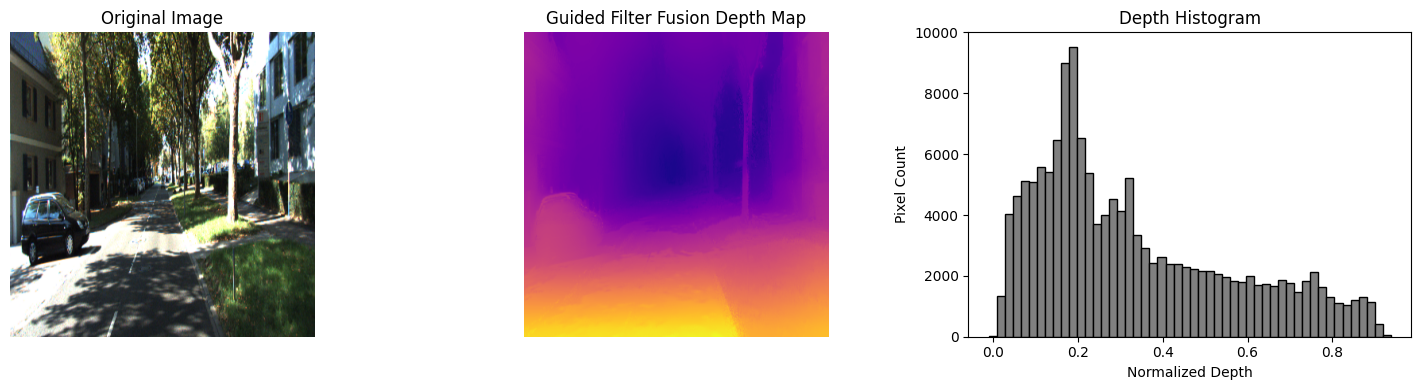

In [ ]:
# --- Perform Guided Filter Fusion ---
def guided_filter_fusion(d1, d2):
    return guidedFilter(img_resized, (0.5 * d1 + 0.5 * d2).astype(np.float32), radius=8, eps=1e-2)

fused_guided = guided_filter_fusion(depth_hybrid, depth_large)

# --- Compute evaluation metrics ---
sobel_edges = sobel(fused_guided)
edge_strength = np.mean(sobel_edges)

hist, _ = np.histogram(fused_guided.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)

# --- Print metrics ---
print(f"Approach: Fusion Guided")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(fused_guided, cmap='plasma')
plt.title("Guided Filter Fusion Depth Map")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.hist(fused_guided.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()


Approach: Fusion Triple
Mean Edge Strength: 0.0048
Shannon Entropy: 5.2263


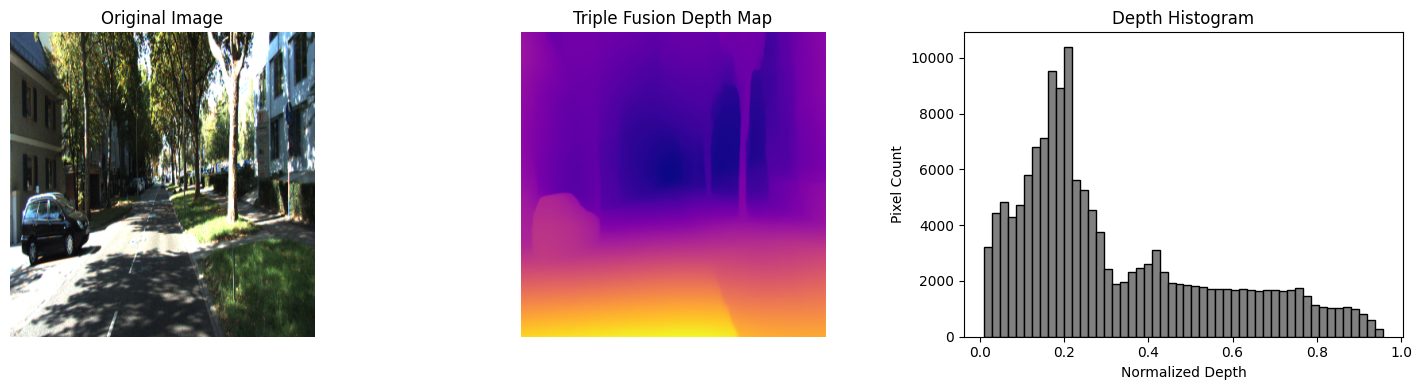

In [ ]:
# --- Perform Triple Fusion (weighted) ---
fused_triple = 0.3 * depth_small + 0.4 * depth_hybrid + 0.3 * depth_large

# --- Compute evaluation metrics ---
sobel_edges = sobel(fused_triple)
edge_strength = np.mean(sobel_edges)

hist, _ = np.histogram(fused_triple.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)

# --- Print metrics ---
print(f"Approach: Fusion Triple")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(fused_triple, cmap='plasma')
plt.title("Triple Fusion Depth Map")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.hist(fused_triple.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()


Approach: Fusion Laplacian
Mean Edge Strength: 0.0055
Shannon Entropy: 5.2820


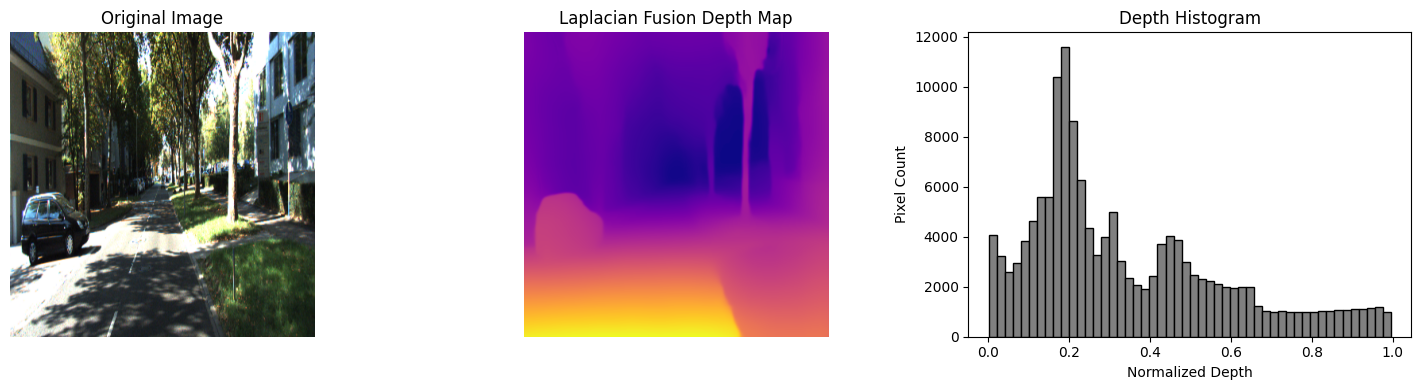

In [ ]:
# --- Perform Laplacian Fusion ---
def laplacian_fusion(base, detail):
    base_blur = cv2.GaussianBlur(base, (5, 5), 0)
    lap_detail = cv2.Laplacian(detail.astype(np.float32), cv2.CV_32F)
    return np.clip(base_blur + 0.3 * lap_detail, 0, 1)

fused_laplacian = laplacian_fusion(depth_hybrid, depth_large)

# --- Compute evaluation metrics ---
sobel_edges = sobel(fused_laplacian)
edge_strength = np.mean(sobel_edges)

hist, _ = np.histogram(fused_laplacian.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)

# --- Print metrics ---
print(f"Approach: Fusion Laplacian")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(fused_laplacian, cmap='plasma')
plt.title("Laplacian Fusion Depth Map")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.hist(fused_laplacian.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()


Approach: Fusion Gaussian
Mean Edge Strength: 0.0048
Shannon Entropy: 5.1911


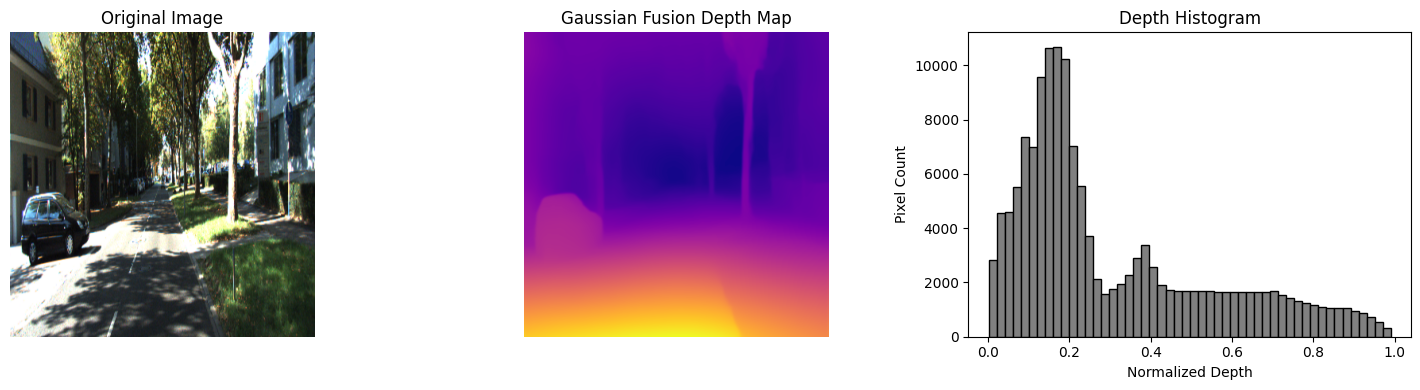

In [ ]:
# --- Perform Gaussian Fusion ---
def gaussian_fusion(d1, d2):
    return cv2.GaussianBlur(0.7 * d1 + 0.3 * d2, (5, 5), sigmaX=1)

fused_gaussian = gaussian_fusion(depth_small, depth_hybrid)

# --- Compute evaluation metrics ---
sobel_edges = sobel(fused_gaussian)
edge_strength = np.mean(sobel_edges)

hist, _ = np.histogram(fused_gaussian.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)

# --- Print metrics ---
print(f"Approach: Fusion Gaussian")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(fused_gaussian, cmap='plasma')
plt.title("Gaussian Fusion Depth Map")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.hist(fused_gaussian.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()


Approach: Fusion Adaptive Variance
Mean Edge Strength: 0.0281
Shannon Entropy: 4.8733


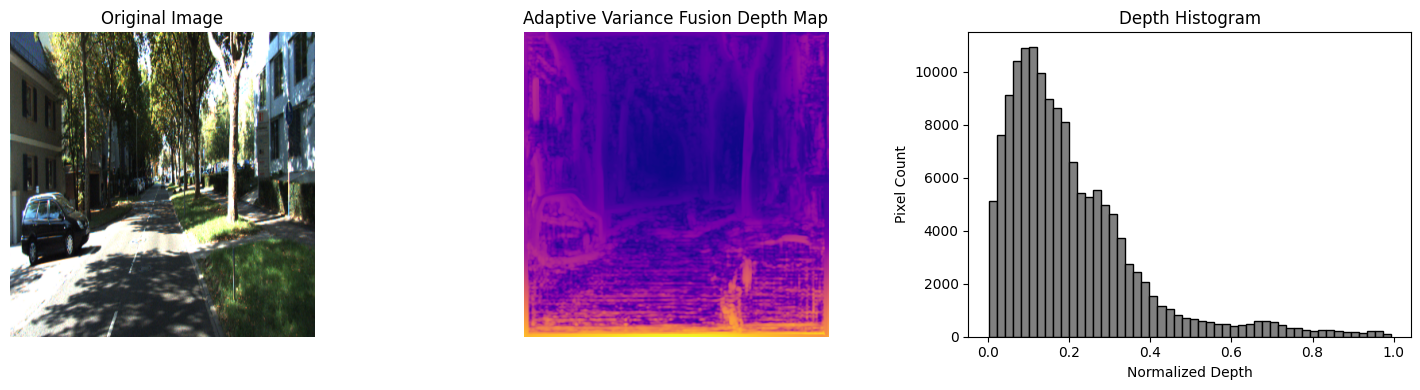

In [ ]:
# --- Perform Adaptive Variance Fusion ---
def adaptive_variance_fusion(d1, d2):
    def local_var(img):
        return cv2.GaussianBlur((img - cv2.GaussianBlur(img, (5, 5), 0))**2, (5, 5), 0)
    v1, v2 = local_var(d1), local_var(d2)
    return (d1 * v1 + d2 * v2) / (v1 + v2 + 1e-8)

fused_adaptive_var = adaptive_variance_fusion(depth_small, depth_large)

# --- Compute evaluation metrics ---
sobel_edges = sobel(fused_adaptive_var)
edge_strength = np.mean(sobel_edges)

hist, _ = np.histogram(fused_adaptive_var.flatten(), bins=256, range=(0, 1), density=True)
depth_entropy = shannon_entropy(hist + 1e-12)

# --- Print metrics ---
print(f"Approach: Fusion Adaptive Variance")
print(f"Mean Edge Strength: {edge_strength:.4f}")
print(f"Shannon Entropy: {depth_entropy:.4f}")

# --- Plot visualization ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(fused_adaptive_var, cmap='plasma')
plt.title("Adaptive Variance Fusion Depth Map")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.hist(fused_adaptive_var.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Depth Histogram")
plt.xlabel("Normalized Depth")
plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


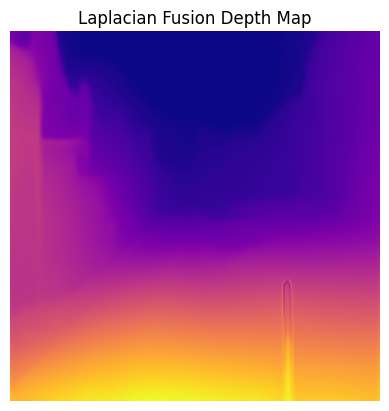

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

# Load MiDaS (small) and DPT_Large models
midas_small = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas_small.eval()

midas_large = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas_large.eval()

# Load and preprocess the image
image_path = "/content/drive/My Drive/EDAI/000005.png"  # Replace with your image path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_batch = transform(img).unsqueeze(0)

# Run depth estimation on both models
with torch.no_grad():
    depth_map_small = midas_small(input_batch).squeeze().cpu().numpy()
    depth_map_large = midas_large(input_batch).squeeze().cpu().numpy()

# Normalize depth maps
depth_map_small = (depth_map_small - depth_map_small.min()) / (depth_map_small.max() - depth_map_small.min())
depth_map_large = (depth_map_large - depth_map_large.min()) / (depth_map_large.max() - depth_map_large.min())

# Laplacian fusion
def laplacian_fusion(base, detail):
    base_blur = cv2.GaussianBlur(base, (5, 5), 0)
    # Ensure that detail is in the right format (float32)
    detail = detail.astype(np.float32)
    lap_detail = cv2.Laplacian(detail, cv2.CV_32F)  # Use CV_32F for floating-point images
    return np.clip(base_blur + 0.3 * lap_detail, 0, 1)

# Apply fusion
lap_fused = laplacian_fusion(depth_map_small, depth_map_large)

# Plot the depth map
plt.imshow(lap_fused, cmap='plasma')
plt.title("Laplacian Fusion Depth Map")
plt.axis("off")
plt.show()



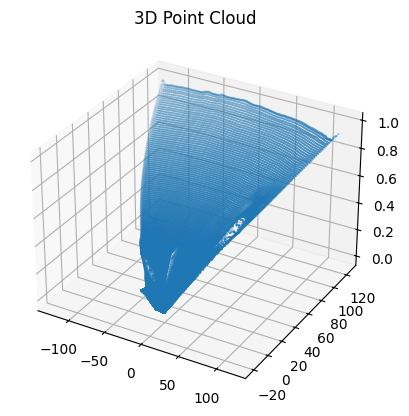

In [ ]:
# Define intrinsic camera parameters (focal length and optical center)
focal_length = 1.0  # You can adjust this for your camera
cx, cy = img.shape[1] // 2, img.shape[0] // 2  # Optical center (assumed in the middle)

# Create the point cloud
def create_point_cloud(depth_map, focal_length, cx, cy):
    h, w = depth_map.shape
    points = []
    for v in range(h):
        for u in range(w):
            z = depth_map[v, u]
            if z > 0:  # Ignore invalid depth values
                x = (u - cx) * z / focal_length
                y = (v - cy) * z / focal_length
                points.append([x, y, z])
    return np.array(points)

# Generate point cloud
point_cloud = create_point_cloud(lap_fused, focal_length, cx, cy)

# Plot point cloud in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.1)
plt.title("3D Point Cloud")
plt.show()


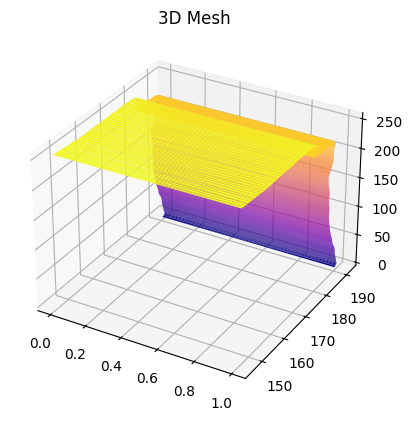

In [ ]:
import numpy as np
from skimage import measure

# Use skimage measure for mesh generation (Marching Cubes)
def generate_mesh(depth_map):
    # Convert depth map to a 3D volume by duplicating along the 3rd axis
    depth_map_3d = np.repeat(np.expand_dims(depth_map, axis=0), 2, axis=0)  # Make it 3D (2xHxW)

    # Set level within the range of the depth map
    level = (depth_map.min() + depth_map.max()) / 2  # Use the midpoint of the min and max values

    # Apply Marching Cubes
    verts, faces, _, _ = measure.marching_cubes(depth_map_3d, level=level)

    return verts, faces

# Generate mesh
verts, faces = generate_mesh(lap_fused)

# Plot 3D mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], cmap='plasma')
plt.title("3D Mesh")
plt.show()


In [ ]:
def save_obj(verts, faces, filename="output.obj"):
    with open(filename, 'w') as f:
        for vert in verts:
            f.write(f"v {vert[0]} {vert[1]} {vert[2]}\n")
        for face in faces:
            f.write(f"f {face[0] + 1} {face[1] + 1} {face[2] + 1}\n")

# Save the mesh to OBJ file
save_obj(verts, faces)
print("3D Mesh saved as output.obj")


3D Mesh saved as output.obj


In [ ]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 15.9 MB/s eta 0:00:00


NameError: name 'depth_map_small' is not defined

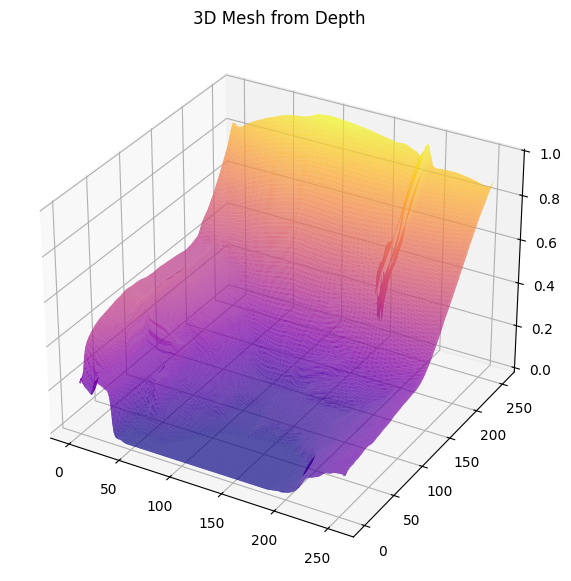

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh

def depth_to_mesh(depth_map, scale=1.0):
    h, w = depth_map.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    # Flatten
    x = xx.flatten() * scale
    y = yy.flatten() * scale
    z = depth_map.flatten() * scale

    # Vertices
    verts = np.stack((x, y, z), axis=-1)

    # Faces (connect 4 adjacent pixels into 2 triangles)
    faces = []
    for i in range(h - 1):
        for j in range(w - 1):
            idx = i * w + j
            faces.append([idx, idx + 1, idx + w])
            faces.append([idx + 1, idx + w + 1, idx + w])
    faces = np.array(faces)

    return verts, faces

# Generate mesh
verts, faces = depth_to_mesh(lap_fused)

# Plot 3D mesh
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='plasma', linewidth=0.2)
ax.set_title("3D Mesh from Depth")
plt.show()

# Save as OBJ using trimesh
mesh = trimesh.Trimesh(vertices=verts, faces=faces)
mesh.export('depth_mesh.obj')

# Optional: Plot point cloud
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c=verts[:, 2], cmap='plasma', s=0.3)
ax.set_title("3D Point Cloud")
plt.show()
